In [78]:
import sys
import os as os
import numpy as np
import polars as pl
import pandas as pd
import geopandas as gpd
import sqlite3
import copy
import itertools
import time 
import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from shapely.geometry import Point
from shapely.ops import unary_union
from dataclasses import dataclass, field
from typing_extensions import List, Dict, Tuple

if 'scicore' in os.getcwd():
    path = '/scicore/home/krysiak/hocrau00/ondemand/OptimalPV_RH'
else:
    path = os.getcwd().split('\\src')[0]
    %load_ext rpy2.ipython

os.chdir(path)
from src.calibration_class import Calibration_Settings, Calibration



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### preprep

In [79]:
if True:
    preprep_list = [
        # Calibration_Settings(), 

        Calibration_Settings(
            name_dir_export='calib_mini_debug',
            name_preprep_subsen='bfs1201',
            bfs_numbers=[1201,],
            rerun_import_and_preprp_data_TF = True,
            export_gwr_ALL_building_gdf_TF = False
        ), 
        Calibration_Settings(
            name_dir_export='calib_mini_debug',
            name_preprep_subsen='bfs1205',
            bfs_numbers=[1205,],
            rerun_import_and_preprp_data_TF = True,
            export_gwr_ALL_building_gdf_TF = False
        ), 
        # Calibration_Settings(
        #     name_dir_export='calib_mini_debug',
        #     name_preprep_subsen='bfs96',
        #     bfs_numbers=[96,],
        #     rerun_import_and_preprp_data_TF = True,
        #     export_gwr_ALL_building_gdf_TF = False
        # ), 
        # Calibration_Settings(
        #     name_dir_export='calib_mini_debug',
        #     name_preprep_subsen='bfs1033',
        #     bfs_numbers=[1033,],
        #     rerun_import_and_preprp_data_TF = True,
        #     export_gwr_ALL_building_gdf_TF = False
        # ), 
    ]

    for i_prep, prep_sett in enumerate(preprep_list):
        print('')
    #     preprep_class = Calibration(prep_sett)
    #     preprep_class.import_and_preprep_data() if preprep_class.sett.rerun_import_and_preprp_data_TF else None

    # preprep_class = Calibration(preprep_list[0])
    # preprep_class.concatenate_prerep_data()


### concat preprep

In [80]:
calib_main_sett = Calibration_Settings(
            name_dir_export='calib_all_CH_bfs',
            scicore_concat_data_path = r'/scicore/home/krysiak/hocrau00/OptimalPV_RH/data/calibration/',
            kt_numbers=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,], 
            # name_preprep_subsen=f'bfs{bfs_number}',
            # bfs_numbers=[bfs_number,], 
            n_rows_import= None,
            rerun_import_and_preprp_data_TF = True,
            export_gwr_ALL_building_gdf_TF = False)
calib_main = Calibration(calib_main_sett)
# calib_main.concatenate_prerep_data()
# calib_main.estimdf2_regression_instsize()

  START CALIBRATION: calib_all_CH_bfs
  > name_preprep_subsen: preprep_class_default_sett
  > name_calib_subscen: calib_class_default_sett



### approach 2 - regression

In [81]:
%%R
if (!requireNamespace("readr", quietly = TRUE)) install.packages("readr")
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("fixest", quietly = TRUE)) install.packages("fixest")
if (!requireNamespace("tibble", quietly = TRUE)) install.packages("tibble")
if (!requireNamespace("jsonlite", quietly = TRUE)) install.packages("jsonlite")
if (!requireNamespace("tidyr", quietly = TRUE)) install.packages("tidyr")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")

library(readr)
library(dplyr)
library(fixest)
library(tibble)
library(jsonlite)
library(tidyr)
library(ggplot2)

In [82]:
%%R
# import
pq_files = list.files(paste0(getwd(), "/data/calibration/calib_all_CH_bfs"), pattern = ".parquet", full.names = TRUE)

df <- tibble(read_csv("C:/Models/OptimalPV_RH/data/calibration/calib_all_CH_bfs/reg2_all_CH_bfs_df_approach2.csv", locale = locale(encoding = "UTF-8")))

# split training & test data
set.seed(42)
train_indices <- sample(1:nrow(df), size = 0.6 * nrow(df))
df_train <- df[train_indices, ]
df_test <- df[-train_indices, ]
print(paste("dim train:", dim(df_train)[1], "dim test:",dim(df_test)[1]))


Rows: 97580 Columns: 13
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (13): EGID, year, BFS_NUMMER, xtf_id, n_DF_UID, InitialPower, TotalPower...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "dim train: 58548 dim test: 39032"


In [83]:
%%R
# fit regression model
fe11 <- feols( TotalPower ~ 
  elecpri_Rp_kWh + pvtarif_Rp_kWh +
  west_max_flaeche + south_max_flaeche + east_max_flaeche,
  data = df_train
)
fe12 <- feols( TotalPower ~
    elecpri_Rp_kWh + pvtarif_Rp_kWh +
    west_max_flaeche + south_max_flaeche + east_max_flaeche | year,
    data = df_train
    )
fe13 <- feols( TotalPower ~
    elecpri_Rp_kWh + pvtarif_Rp_kWh +
    west_max_flaeche + south_max_flaeche + east_max_flaeche | BFS_NUMMER,
    data = df_train
    )
fe14 <- feols( TotalPower ~
    elecpri_Rp_kWh + pvtarif_Rp_kWh +
    west_max_flaeche + south_max_flaeche + east_max_flaeche | BFS_NUMMER + year,
    data = df_train
    )

fe21 <- feols(
  TotalPower ~ 
    elecpri_Rp_kWh + I(elecpri_Rp_kWh^2) +
    pvtarif_Rp_kWh + I(pvtarif_Rp_kWh^2) +
    west_max_flaeche + I(west_max_flaeche^2) +
    south_max_flaeche + I(south_max_flaeche^2) +
    east_max_flaeche + I(east_max_flaeche^2) |
    BFS_NUMMER + year,
  data = df_train
)
fe22 <- feols(
    TotalPower ~ 
      elecpri_Rp_kWh + log(elecpri_Rp_kWh) +
      pvtarif_Rp_kWh + log(pvtarif_Rp_kWh) +
      west_max_flaeche + I(west_max_flaeche^2) +
      south_max_flaeche + I(south_max_flaeche^2) +
      east_max_flaeche + I(east_max_flaeche^2) |
      BFS_NUMMER + year,
    data = df_train
  )
fe23 <- feols(
    TotalPower ~ 
      elecpri_Rp_kWh + log(elecpri_Rp_kWh) +
      pvtarif_Rp_kWh + log(pvtarif_Rp_kWh) +
      west_max_flaeche + I(west_max_flaeche^2) +
      south_max_flaeche + I(south_max_flaeche^2) +
      east_max_flaeche + I(east_max_flaeche^2),
    data = df_train
  )



NOTE: 1,824 observations removed because of NA values (RHS: 1,824).
NOTE: 1,824 observations removed because of NA values (RHS: 1,824, Fixed-effects: 82).
NOTES: 1,824 observations removed because of NA values (RHS: 1,824).
       3 fixed-effect singletons were removed (3 observations).
NOTES: 1,824 observations removed because of NA values (RHS: 1,824, Fixed-effects: 82).
       3/0 fixed-effect singletons were removed (3 observations).
NOTES: 1,824 observations removed because of NA values (RHS: 1,824, Fixed-effects: 82).
       3/0 fixed-effect singletons were removed (3 observations).
NOTES: 1,884 observations removed because of NA and infinite values (RHS: 1,884, Fixed-effects: 82).
       3/0 fixed-effect singletons were removed (3 observations).
NOTE: 1,884 observations removed because of NA and infinite values (RHS: 1,884).


In [84]:
%%R
# Predict TotalPower for each model
df_test$pred_fe11 <- predict(fe11, newdata = df_test)
df_test$pred_fe12 <- predict(fe12, newdata = df_test)
df_test$pred_fe13 <- predict(fe13, newdata = df_test)
df_test$pred_fe14 <- predict(fe14, newdata = df_test)
df_test$pred_fe21 <- predict(fe21, newdata = df_test)
df_test$pred_fe22 <- predict(fe22, newdata = df_test)
df_test$pred_fe23 <- predict(fe23, newdata = df_test)

rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted)^2, na.rm = TRUE))
}
rmse_results <- data.frame(
  Model = c("fe11", "fe12", "fe13", "fe14", "fe21", "fe22", "fe23"),
  RMSE = c(
    rmse(df_test$TotalPower, df_test$pred_fe11),
    rmse(df_test$TotalPower, df_test$pred_fe12),
    rmse(df_test$TotalPower, df_test$pred_fe13),
    rmse(df_test$TotalPower, df_test$pred_fe14),
    rmse(df_test$TotalPower, df_test$pred_fe21),
    rmse(df_test$TotalPower, df_test$pred_fe22),
    rmse(df_test$TotalPower, df_test$pred_fe23)
  )
)
print(rmse_results)


  Model     RMSE
1  fe11 5.938528
2  fe12 5.933040
3  fe13 5.291688
4  fe14 5.292002
5  fe21 5.259398
6  fe22      Inf
7  fe23      Inf


In [85]:
%%R 
# etable(fe11,fe21)

NULL


In [86]:
%%R
# etable(fe11, fe12)

NULL


In [87]:
%%R
# etable(fe13, fe14)

NULL


In [88]:
%%R
# etable(fe21,fe22)

NULL


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 7983 rows containing missing values or values outside the scale range
(`geom_point()`). 
  


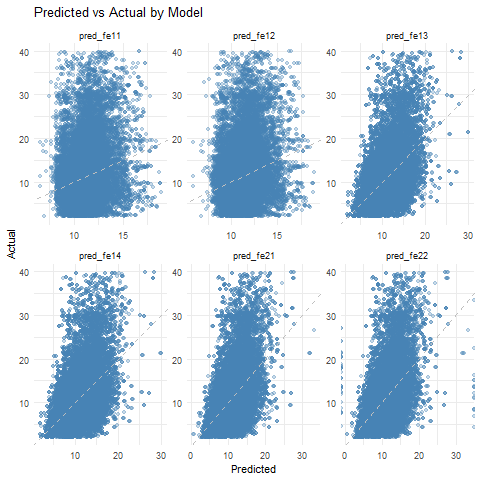

In [89]:
%%R
df_long <- df_test %>%
  select(TotalPower, pred_fe11, pred_fe12, pred_fe13, pred_fe14, pred_fe21, pred_fe22) %>%
  pivot_longer(
    cols = starts_with("pred_fe"),
    names_to = "Model",
    values_to = "Prediction"
  )

# ggplot(df_long, aes(x = Prediction, y = TotalPower, color = Model)) +
#   geom_point(alpha = 0.4) +
#   geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
#   labs(title = "Predicted vs Actual TotalPower",
#        x = "Predicted TotalPower", y = "Actual TotalPower") +
#   theme_minimal()

ggplot(df_long, aes(x = Prediction, y = TotalPower)) +
  geom_point(alpha = 0.3, color = "steelblue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  facet_wrap(~ Model, scales = "free") +
  labs(title = "Predicted vs Actual by Model",
       x = "Predicted", y = "Actual") +
  theme_minimal()


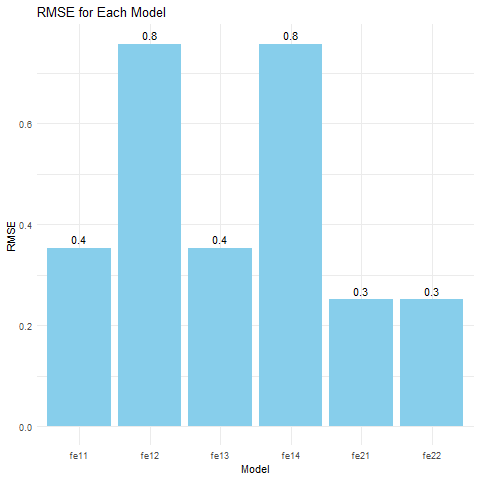

In [23]:
%%R
ggplot(rmse_results, aes(x = Model, y = RMSE)) +
  geom_col(fill = "skyblue") +
  geom_text(aes(label = round(RMSE, 1)), vjust = -0.5) +
  labs(title = "RMSE for Each Model", y = "RMSE", x = "Model") +
  theme_minimal()


In [ ]:
# %%R
# calib_path = "C:/Models/OptimalPV_RH/data/calibration/calib_all_CH_bfs/"
# extract_coef_dict <- list(
#     fe11 = list(
#         comment="Linear model without fixed effects",
#         coefficients = as.list(coef(fe11))  
#     ),
#     fe21 = list(
#         comment="Quadratic model (linear + ^2 for each covariate) with fixed effects for BFS_NUMMER and year",
#         coefficients = as.list(coef(fe21))  
#     )

# )
# write_json(extract_coef_dict, paste0(calib_path, "/reg2_export_model_coef.json"), pretty = TRUE, auto_unbox = TRUE)

In [34]:
%%R
getwd()

[1] "c:/Models/OptimalPV_RH"
